# Convergence Test 
Only trust those don't change under different resolutions.

In [1]:
from functions import Plasma, Spectral
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import lambertw
from tqdm import tqdm

W = lambda z,k: np.real(lambertw(z,k=k)) # I only need the real parts

In [3]:
def velocity_profile(M, Mm, x, constant_velocity=False,acclerting=True):
    if constant_velocity:
        v = Mm*np.ones_like(x) # constant v=0.1
        return v

    if Mm < 1:
        v = M(x, Mm=Mm, k=0) # subsonic velocity profile, M_m = 0.1
    elif Mm == 1:
        if acclerting:
            v = np.concatenate([M(x[x<0], Mm=1, k=0), [1], M(x[x>0], Mm=1, k=-1)]) # accelerating velocity profile
        else:
            v = np.concatenate([M(x[x<0], Mm=1, k=-1), [1], M(x[x>0], Mm=1, k=0)]) # decelerating velocity profile
    else:
        v = M(x, Mm=Mm, k=-1) # supersonic velocity profile
    return v


In [18]:
Mm = 1.5
accelerating = False
constant_velocity = False
B0 = 1
R = 1.5
Bm = 1+R
Delta = 0.1/0.3
B = lambda z: B0*(1+R*np.exp(-(z/Delta)**2))
M = lambda z, Mm, k: np.sqrt( -W(-Mm**2 * (B(z)/Bm)**2 * np.exp(-Mm**2), k=k) )

N_range = np.arange(51,302,50)
omegas = []
Vs = []
for N in tqdm(N_range):
    spectral = Spectral(N,"symmetric","FD")
    x = spectral.x
    D1 = spectral.D1
    D2 = spectral.D2
    v0 = velocity_profile(M, Mm, x, constant_velocity, accelerating)

    A11 = np.zeros_like(D1)
    A12 = np.eye(*D1.shape)
    A21 = -np.diag(1-v0**2)@D2 \
            + np.diag((3*v0 + 1/v0)*(D1@v0))@D1 \
            + np.diag((1-1/v0**2)*(D1@v0)**2) \
            + np.diag((v0+1/v0)*(D2@v0))
    A22 = -2j*(np.diag(v0)@D1 + np.diag(D1@v0))

    A = np.block([[A11[1:-1,1:-1], A12[1:-1,1:-1]],[A21[1:-1,1:-1], A22[1:-1,1:-1]]])
    omega, V = np.linalg.eig(A)
    omegas.append(omega)
    V = V[:int(V.shape[0]/2),:]
    Vs.append(np.pad(V, ((1,1),(0,0))))

100%|██████████| 6/6 [00:06<00:00,  1.00s/it]


Text(0, 0.5, '$\\Im(\\omega)$')

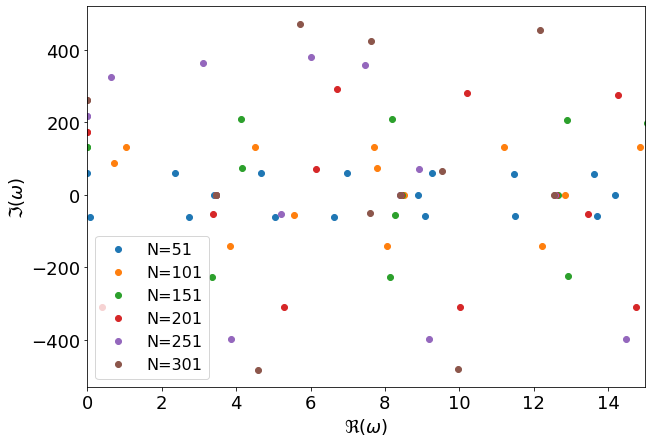

In [23]:
# phase space
plt.figure(figsize=(10,7))

for i, N in enumerate(N_range):
    omega = omegas[i]
    plt.plot(omega.real, omega.imag, 'o', label=f"N={N}")
plt.legend()
plt.xlim(0,15)
# plt.ylim(-10,10)
plt.xlabel("$\Re(\omega)$")
plt.ylabel("$\Im(\omega)$")

Text(0, 0.5, 'v')

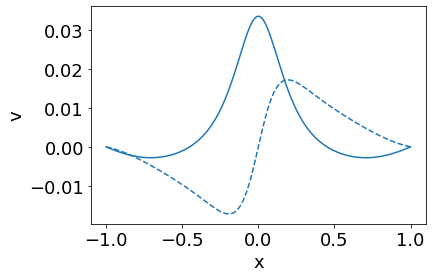

In [21]:
omega = omegas[-1]
V = Vs[-1]
selection = (np.abs(omega.real-3)<1) & (np.abs(omega.imag)<1)
w = omega[selection]
v = V[:,selection]
plt.plot(x,v.real,color="C0",label=f"$\omega=${w}")
plt.plot(x,v.imag,"--",color="C0",label=f"$\omega=${w}")
plt.xlabel("x")
plt.ylabel("v")

In [16]:
x.shape

(301,)